In [1]:
import numpy as np
import re
import torch
import torch.nn as nn
import torch.utils.data as utils
import numpy as np
import torch.nn.functional as F

In [2]:
# Pre-processing

In [3]:
shakespeare = 'shakespeare.txt'
spenser = 'spenser.txt'
syllable_dict = 'Syllable_dictionary.txt'

In [4]:
# dict
sylDict ={}
lenL = set()
with open(syllable_dict) as f:
    for l in f:
        lst = l.split(' ')
        lenL.add(len(lst))
        if len(lst) == 2:
            sylDict[lst[0]] = int(lst[1].replace('\n', ''))
        else:
            e = int(lst[1].replace('E', '').replace('\n', ''))
            n = int(lst[2].replace('E', '').replace('\n', ''))
            sylDict[lst[0]] = (e+n)/2

Problem A. 

i.
I lowercased all the words, got rid of roman numerals and excessive line change characters, and tokenized each characters before i one-hot encoded them. A sequence consist of one-hot encoded version of 40 characters. I left the y value in the form of just tokenization, so just numbers representing each character instead of one-hot encoding them. I first tried one-hot encoding the y values as well and the model would just spit out Grrrr. I also tried tokenize each word instead of characters, and using various n-grams as my x values. Which garantteed the model spitting out actual words, but no line changes anymore. Also the instruction clearly states each sequence should be 40 characters, so I abondoned that approach eventhough it gave me more sensible outputs. My initial thought is that the model shouldn't be making up words, because that just woundn't make sense. But after many trials and errors, the "words" the model spitted out are mostly actual words. I believe with a more complex model it will be able to spit out more sensible sentences. I also combined both txt files so I would have a larger training sample. Each possible 40 character sequence was a training sample, except for maybe the last one. But to speed up training, I sampled every 15 sequences. 

ii.
I checked the average syllable count for each "stence," which didn't help much in my case, since I ended up choosing a character based approach, and I wasn't able to incoperate word's pronounciation into one of the features. I also checked most common characters, words, and symbols, which help me realized my model was spitting out the most common character after the last input character in one of my failed attempts.

In [16]:
# txt file processing
def process_text(filePasses):
    dataSh = open(filePasses[0], 'r').read().lower()
    dataSp = open(filePasses[0],'r').read()
    dataSp = re.sub('[A-Z]+\n\n', '', dataSp)
    dataSp = dataSp.lower()
    data = dataSh + dataSp
    dataText = re.sub('\d+', '', data)
    dataText = re.sub(' +', ' ', dataText)
    dataSet = list(set(dataText))
    int2char = dict(enumerate(dataSet))
    char2int = {c: i for i, c in int2char.items()}
    data = np.array([char2int[ch] for ch in dataText])

    return dataText, dataSet, int2char, char2int, data

text, chars, int2char, char2int, data = process_text([shakespeare, spenser])



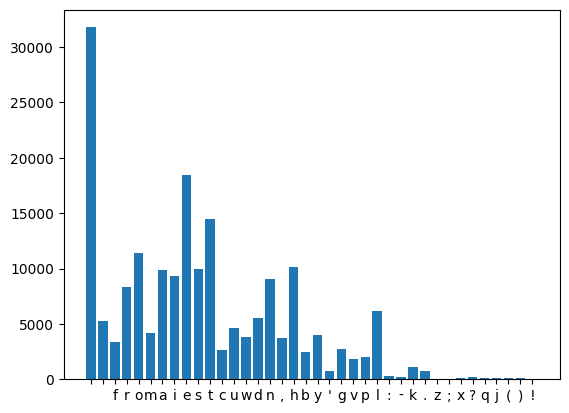

In [15]:
import matplotlib.pyplot as plt

count = {}
for i in text:
    if i in count.keys():
        count[i] += 1
    else:
        count[i] = 1
plt.bar(range(len(count)), list(count.values()), tick_label=list(count.keys()))
plt.show()

In [17]:
# pre training 
seq_length = 40
charsSize = len(chars)
slices = len(text) - 1 - seq_length

X = np.zeros((slices, seq_length, charsSize))
y = np.zeros((slices, seq_length))

for i in range(0, slices):
    X_sequence = text[i:i+seq_length]
    X_sequence_ix = [char2int[value] for value in X_sequence]
    input_sequence = np.zeros((seq_length, charsSize))
    for j in range(seq_length):
        input_sequence[j][X_sequence_ix[j]] = 1.
    X[i] = input_sequence

    y_sequence = data[i+1: i+seq_length+1]
    y[i] = y_sequence


In [18]:
n = 15
X = torch.tensor(X)
y = torch.tensor(y)
y = y.type(torch.LongTensor)
X = X[::n]
y = y[::n]
train = utils.TensorDataset(X, y)

In [19]:
batch_size = 100
train_dataloader = utils.DataLoader(train, batch_size = batch_size, drop_last = True)


Problem B:

i. The model I implemended has two layers, one LSTM w 200 hidden units, and a one-hot encoding of a character being the input, and a fully connected layer that outputs all possible characters and their corresponding possibilities. To predict, I draw the most likely character. Sequence length is 40, sampling every 15 input data as training. I wasn't too concerned with overfitting, since it is a relatively simple model. The final learning rate is .005 and I find training for 100 epoachs to be sufficient enough. The poem I ended up generating was mid. The model spitted out mostly recognizable words but it failed to follow the structure very strickly, but that might be the sequence isn't long enough or that the model was too simple. 

ii.
I trained on around 180000 training points, sampled every 15 set so a little more than 10000 training examples, for 100 epochs. The model didn't really learn the structure, but some of the outputs I got suggested that I does break things into stances and poems. 

iii.
The output is all the way in the end.
From what I can tell, the lower the temperature is the more likely it is for the output to make sense


In [20]:
#model
class ShakespeareLSTM(nn. Module):
    
    def __init__(self, n_hidden, n_layers, lr, T):
        super().__init__()
        self.lr = lr
        self.n_layers = n_layers
        self.hidden_size = n_hidden
        self.seq_length = 40
        self.input_size = 38
        self.output_size = self.input_size
        
        #layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, 
                            batch_first = True)
        self.FC = nn.Linear(self.hidden_size, self.output_size)

        
        
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = out.reshape(-1,self.hidden_size)
        out = self.FC(out)
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        hidden = (weights.new(self.n_layers, batch_size, self.hidden_size).zero_(),
                  weights.new(self.n_layers, batch_size, self.hidden_size).zero_())
        return hidden
    

In [38]:
X.shape, y.shape

(torch.Size([12610, 40, 38]), torch.Size([12610, 40]))

In [21]:
def train(model, epochs, lr):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lossF = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        h = model.init_hidden(batch_size)
        for X, y in train_dataloader:
            h = tuple([each.data for each in h])
            optimizer.zero_grad()
            output, h = model(X.float(), h)
            loss = lossF(output, y.view(batch_size*40))
            epoch_loss += loss
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_dataloader)}")
        
    return model
        



In [25]:
# Hyperparameters
n_hidden = 200
n_layers = 1
lr = 0.005
epochs = 40

m = ShakespeareLSTM(n_hidden,n_layers,lr,None)

In [26]:
##Train the model
outModel = train(m, epochs, lr)

Epoch: 1 Loss:2.522648334503174
Epoch: 2 Loss:1.994085669517517
Epoch: 3 Loss:1.8164949417114258
Epoch: 4 Loss:1.7089512348175049
Epoch: 5 Loss:1.6292895078659058
Epoch: 6 Loss:1.5588490962982178
Epoch: 7 Loss:1.5033636093139648
Epoch: 8 Loss:1.458914041519165
Epoch: 9 Loss:1.4148130416870117
Epoch: 10 Loss:1.370316982269287
Epoch: 11 Loss:1.3422300815582275
Epoch: 12 Loss:1.3108000755310059
Epoch: 13 Loss:1.2782973051071167
Epoch: 14 Loss:1.2519302368164062
Epoch: 15 Loss:1.2331702709197998
Epoch: 16 Loss:1.2203878164291382
Epoch: 17 Loss:1.2019574642181396
Epoch: 18 Loss:1.175187349319458
Epoch: 19 Loss:1.1510448455810547
Epoch: 20 Loss:1.1270962953567505
Epoch: 21 Loss:1.108883261680603
Epoch: 22 Loss:1.095689058303833
Epoch: 23 Loss:1.0836652517318726
Epoch: 24 Loss:1.0761500597000122
Epoch: 25 Loss:1.064795732498169
Epoch: 26 Loss:1.049681544303894
Epoch: 27 Loss:1.040641188621521
Epoch: 28 Loss:1.0271307229995728
Epoch: 29 Loss:1.0156227350234985
Epoch: 30 Loss:1.0100957155227661

In [27]:
def predict(model, start, T, h):
    model.eval() 
    x = [char2int[i] for i in start]
    for i in range(len(x)):
        b = np.zeros(38)
        b[x[i]] = 1
        x[i] = b
    x = [x]
    x = torch.tensor(x, dtype = torch.float)
    h = tuple([i.data for i in h])
    output, h = model(x,h)
    p = F.softmax(output/T,dim =1)
    p = p[0]
    character = int2char[int(torch.argmax(p))]
    return character,h


def generate_text(model, start, T, num_char):
    model.eval()
    chars = list(start)
    h = model.init_hidden(1)  
    for i in start:
        char,h = predict(model, i, T, h)
    chars.append(char)
    
    for i in range(num_char):
        char,h = predict(model, chars[-1], T, h)
        chars.append(char)
        
    return "".join(chars)
    

In [28]:
s = "shall i compare thee to a summer's day? \n"

In [31]:
gentext150 = generate_text(outModel, s, 1.5, 500)
gentext075 = generate_text(outModel, s, 0.75, 500)
gentext025 = generate_text(outModel, s, 0.25, 500)
print(gentext150)

/var/folders/76/2ttwxdjj1qx_z9ztrhctc3nw0000gp/T/ipykernel_92554/929942359.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:276.)
  x = torch.tensor(x, dtype = torch.float)


shall i compare thee to a summer's day? 

 
then decreess of a conscience is my heart to says i do this played the breath the power to grace i swear that which thou dost have profined,
or all the substance sounds with pleasure of thy hungs of light,
where art thou my love, say the power to remavely boind doth bears
my self thy beauty being made of their gld the stars in secred in the world to my deeds,
thou mak'st true sight,
and suppest i from my sin, and they so is place,
 whilst my body to his sweet husbandry of a fair a mannigal my 


In [32]:
print(gentext075)

shall i compare thee to a summer's day? 

 
then decreess of a conscience is my heart to says i do this played the breath the power to grace i swear that which thou dost have profined,
or all the substance sounds with pleasure of thy hungs of light,
where art thou my love, say the power to remavely boind doth bears
my self thy beauty being made of their gld the stars in secred in the world to my deeds,
thou mak'st true sight,
and suppest i from my sin, and they so is place,
 whilst my body to his sweet husbandry of a fair a mannigal my 


In [33]:
print(gentext025)

shall i compare thee to a summer's day? 

 
then decreess of a conscience is my heart to says i do this played the breath the power to grace i swear that which thou dost have profined,
or all the substance sounds with pleasure of thy hungs of light,
where art thou my love, say the power to remavely boind doth bears
my self thy beauty being made of their gld the stars in secred in the world to my deeds,
thou mak'st true sight,
and suppest i from my sin, and they so is place,
 whilst my body to his sweet husbandry of a fair a mannigal my 
